<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125">
</div>

# 安装所有依赖

In [1]:
# 安装所需要的依赖
%%capture

!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth
!pip install modelscope

# 装载google云盘（用于存储训练数据和模型权重）




In [2]:
# 转载google云盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 下载数据集（包含了训练集+测试集）


In [ ]:
# 从model_scope下载数据集
!modelscope download --dataset zhangzhihao/Simplified_Chinese_Multi-Emotion_Dialogue_Dataset --local_dir "/content/drive/MyDrive/Colab Notebooks/data_set"

Processing 4 items:   0% 0.00/4.00 [00:00<?, ?it/s]






Processing 4 items:  25% 1.00/4.00 [00:00<00:02, 1.01it/s]







Processing 4 items:  75% 3.00/4.00 [00:01<00:00, 3.23it/s]












Processing 4 items: 100% 4.00/4.00 [00:01<00:00, 2.39it/s]


# 下载模型权重
注意: 如果先前已经下载了，请忽略这一步。

In [ ]:
# 下载模型
from transformers import AutoModelForCausalLM, AutoTokenizer

# 下载模型和分词器
model = AutoModelForCausalLM.from_pretrained("unsloth/Qwen3-8B-unsloth-bnb-4bit", cache_dir="/content/drive/MyDrive/models/qwen3-8b-4bit")  # 替换为模型名称和本地目录
tokenizer = AutoTokenizer.from_pretrained("unsloth/Qwen3-8B-unsloth-bnb-4bit", cache_dir="/content/drive/MyDrive/models/qwen3-8b-4bit")  # 替换为模型名称和本地目录

config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/144k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

# 通过unsloth加载模型合分词器

In [3]:
from unsloth import FastLanguageModel
import torch

# 记载模型和分词器
model, tokenizer = FastLanguageModel.from_pretrained(
  model_name = "/content/drive/MyDrive/models/qwen3-8b-4bit/models--unsloth--Qwen3-8B-unsloth-bnb-4bit/snapshots/bf42c87707c4a33a40adaffc3813203ed4aab203",
  max_seq_length = 2048,   # 对显存有影响，可按需调整
  load_in_4bit = True,     # 使用4bit的量化模型（from unsloth）
  load_in_8bit = False,
  full_finetuning = False, # 不考虑全参数微调
  # cache_dir="/content/drive/MyDrive/models" # 第二次加载后则不需要开启
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.1: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## 查看token概率

In [10]:
import torch

messages = [
    {"role" : "user", "content" : "你是谁"}
  ]

text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True,
    enable_thinking = False,
)

# 使用模型生成结果
inputs = tokenizer(text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=10, output_scores=True, return_dict_in_generate=True)

# 获取所有token的logits
scores = outputs.scores

# 只获取第一个生成token的logits
first_token_logits = scores[0]

# 将logits转换为概率
probabilities = torch.softmax(first_token_logits, dim=-1)

# 获取top10的token及其概率
topk_probs, topk_indices = torch.topk(probabilities[0], 10)

# 输出top10的token及其概率
for i in range(10):
    token_id = topk_indices[i].item()
    token_text = tokenizer.decode(token_id)
    token_prob = topk_probs[i].item()
    print(f"Token: {token_text}, Probability: {token_prob}")

Token: 我是, Probability: 1.0
Token: ", Probability: 0.0
Token: $, Probability: 0.0
Token: ', Probability: 0.0
Token: (, Probability: 0.0
Token: !, Probability: 0.0
Token: #, Probability: 0.0
Token: &, Probability: 0.0
Token: ), Probability: 0.0
Token: %, Probability: 0.0


# 数据集载入

In [4]:
from datasets import load_dataset

# 加载数据集
dataset = load_dataset("csv", data_files="/content/drive/MyDrive/Colab Notebooks/data_set/Simplified_Chinese_Multi-Emotion_Dialogue_Dataset.csv")

Generating train split: 0 examples [00:00, ? examples/s]

## 数据集格式查看

In [5]:
# 查看数据集前5行相关信息
dataset["train"].take(5).to_pandas()

,text,label
0,你想不想去吃午饭？,平静
1,哦！我被选中了！,开心
2,我几天身体好像有点不太舒服，肚子好痛。,伤心
3,我的小组成员一个都没干活！真后悔跟他一起组队。,生气
4,他们是不是吵架了？不会打起来吧？,平静


## 训练集/测试集合划分

In [5]:
# 对数据集进行划分（仅划分为训练集和测试机）
train_testvalid = dataset["train"].train_test_split(test_size=0.03, seed=42)  # test_size 指定测试集比例，seed 用于随机数生成

train_dataset = train_testvalid["train"]
eval_dataset = train_testvalid["test"]

## 查看数据集分布情况

In [7]:
train_df = train_dataset.to_pandas()

# 对DataFrame按照label列进行分组，并获取每个分组的大小
label_counts = train_df.groupby('label').size()

label_counts

,0
label,
伤心,477
关心,542
厌恶,392
平静,685
开心,570
惊讶,492
生气,503
疑问,373


In [8]:
eval_df = eval_dataset.to_pandas()

# 对 DataFrame 按照 label 列进行分组，并获取每个分组的大小
label_counts = eval_df.groupby('label').size()

label_counts

,0
label,
伤心,9
关心,18
厌恶,12
平静,20
开心,22
惊讶,7
生气,24
疑问,13


## 构造prompt尝试推理

In [4]:
def generate_prompt(question):
  prompt = ("你是一个中文情感分析大师，你擅长对用户问题中的情感进行分类。"
        "\n\n"
        "任务说明"
        "\n你需要根据用户问题从[伤心]、[关心]、[厌恶]、[平静]、[开心]、[惊讶]、[生气]和[疑问]中选择一类。"
        "\n\n"
        "要求输出的格式为：<classification>你的分类结果</classification>"
        "\n\n"
        f"\n用户问题：{question}")
  return prompt

In [7]:
def generate(question: str):
  prompt = generate_prompt(question)
  messages = [
    {"role" : "user", "content" : prompt}
  ]
  # 使用模型生成结果
  text = tokenizer.apply_chat_template(
      messages,
      tokenize = False,
      add_generation_prompt = True,
      enable_thinking = False,
  )
  # 调用模型生成结果
  eos_token_id = tokenizer.eos_token_id
  # 将text转换成token
  inputs = tokenizer(text, return_tensors="pt").to("cuda")
  input_ids = inputs.input_ids
  attention_mask = inputs.attention_mask
  # 推理生成
  outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=100, use_cache=True, temperature=0.6, top_p=0.95, top_k=20)
  # 获取new_token的id
  new_token_ids = outputs[:, input_ids.shape[1]:]
  # 将 new_token 部分的 token ID 解码为文本
  new_token = tokenizer.decode(new_token_ids[0], skip_special_tokens=True)
  return new_token

In [11]:
# 调用模型进行推理尝试
generate("你好")

'<classification>平静</classification>'

## 对未训练前的模型进行效果评估

In [12]:
import pandas as pd
import re
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def batch_evaluate(dataset):
  """批量评测结果，并将结果保存到 CSV 文件中，并统计最终的正确率。

  Args:
    dataset: 数据集，包含 'text' 和 'label' 两列。
    num_workers: 并发工作线程数。

  Returns:
    最终的正确率。
  """
  results = []

  def evaluate_single(example):
    """评估单个样本。"""
    index, row = example
    text = row.text
    label = row.label
    try:
      generated_text = generate(text)  # 调用 generate 函数获取生成结果

      # 使用正则表达式提取 <classification></classification> 标签内的内容
      match = re.search(r"<classification>(.*?)</classification>", generated_text)

      if match:
        predicted_label = match.group(1)
        is_correct = predicted_label == label
        result = {'text': text, 'label': label, 'predicted_label': predicted_label, "model_response": generated_text, 'is_correct': is_correct, 'format': True}
      else:
        result = {'text': text, 'label': label, 'predicted_label': None, "model_response": generated_text, 'is_correct': False, 'format': False}
    except Exception as e:
      result = {'text': text, 'label': label, 'predicted_label': None, 'is_correct': False, 'format_error': True, 'error': str(e)}

    return result

  for example in tqdm(dataset.iterrows(), total=len(dataset), desc="数据处理中..."):
    result = evaluate_single(example)
    results.append(result)

  # 将结果保存到 CSV 文件中
  df = pd.DataFrame(results)
  df.to_csv("/content/drive/MyDrive/eval/base_model_eval.csv", index=False)

  print("Evaluation results saved to evaluation_results.csv")
  return df  # 返回最终的正确率

# 调用 batch_evaluate() 函数并获取最终的正确率
df = batch_evaluate(eval_df)

数据处理中...: 100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Evaluation results saved to evaluation_results.csv


In [13]:
accuracy = len(df[df["is_correct"] == True]) / len(df)

accuracy

0.792

# 模型训练

## 配置lora训练参数

In [8]:
model = FastLanguageModel.get_peft_model(
  model,
  r = 32,           # 矩阵秩的大小，建议值：8, 16, 32, 64, 128
  target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
  lora_alpha = 32,  # 控制lora参数对输出结果的影响，建议值：alpha = rank or rank*2
  lora_dropout = 0, # 随机控制神经元的输出为0，防止模型过拟合
  bias = "none",    # 默认none
  use_gradient_checkpointing = "unsloth", # 使用unsloth
  random_state = 3407,
  use_rslora = False,   # RSLoRA (Rank-Stabilized LoRA) 是一种改进版的 LoRA (Low-Rank Adaptation) 技术，它通过调整适配器缩放因子来提高模型的稳定性和性能。
  loftq_config = None,  # LoftQ (Low-bit and Fast Quantization of Transformer) 是一种量化技术，它可以将模型的权重压缩到更低的位数，从而减少模型的内存占用和推理时间。
)

Unsloth 2025.4.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


## 处理训练数据（转换为chat格式）

In [9]:
def generate_conversation(examples):
  texts = examples["text"]
  labels = examples["label"]
  conversations = []
  for text, label in zip(texts, labels):
    conversations.append([
        {"role" : "user", "content" : generate_prompt(text)},
        {"role" : "assistant", "content" : f"	<classification>{label}</classification>"},
    ])
  return {"conversations": conversations}

In [10]:
chat_conversations = tokenizer.apply_chat_template(
    train_dataset.map(generate_conversation, batched = True)["conversations"],
    tokenize = False,
    enable_thinking = False,
)

Map:   0%|          | 0/4034 [00:00<?, ? examples/s]

In [11]:
chat_conversations[0]

'<|im_start|>user\n你是一个中文情感分析大师，你擅长对用户问题中的情感进行分类。\n\n任务说明\n你需要根据用户问题从[伤心]、[关心]、[厌恶]、[平静]、[开心]、[惊讶]、[生气]和[疑问]中选择一类。\n\n要求输出的格式为：<classification>你的分类结果</classification>\n\n\n用户问题：这确实很令人生气，他们做了什么？<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n\t<classification>生气</classification><|im_end|>\n'

In [12]:
# 训练数据准备
import pandas as pd
data =  pd.Series(chat_conversations)
data.name = "text"

from datasets import Dataset
training_dataset = Dataset.from_pandas(pd.DataFrame(data))
training_dataset = training_dataset.shuffle(seed = 1037)

## 开始训练

In [13]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = training_dataset,
    eval_dataset = None, # 评估会比较慢，这里设置为空
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4, # 梯度累积
        warmup_steps = 5, # 热身步数
        num_train_epochs = 1, # 训练一个epoch.
        max_steps = 100,
        learning_rate = 2e-4, # 步数多的话可以调为2e-4
        logging_steps = 1,
        optim = "adamw_8bit", # 优化器设置（默认为adamw）
        weight_decay = 0.01, # 正则惩罚，防止过你和
        lr_scheduler_type = "linear", # 线性学习率
        seed = 1037, # 初始的随机权重
        report_to = "none", # 可以使用wandb
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/4034 [00:00<?, ? examples/s]

In [14]:
# @title 查看显存占用
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
7.395 GB of memory reserved.


开始训练

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,034 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 87,293,952/8,000,000,000 (1.09% trained)


Step,Training Loss
1,0.221400
2,0.199500
3,0.184300
4,0.258800
5,0.144800
6,0.143100
7,0.132400
8,0.111100
9,0.104400
10,0.114100


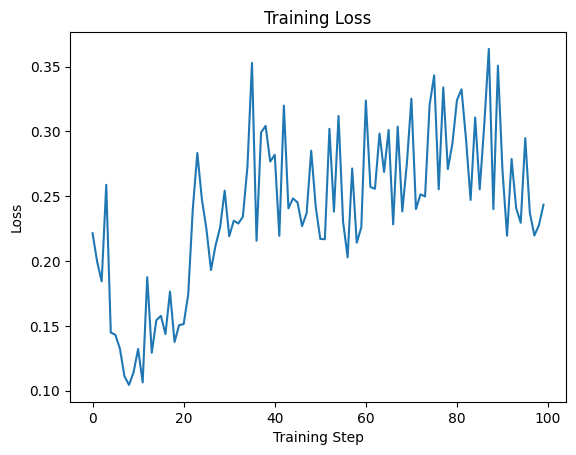

In [20]:
# 训练模型
trainer_stats = trainer.train()

# 初始化一个空列表来存储loss值
loss_values = []

# 获取训练过程中的loss数据
for log_history in trainer.state.log_history:
    if "loss" in log_history.keys():
        loss_values.append(log_history["loss"])

# 绘制loss曲线
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

评估训练好的模型

In [23]:
def generate(question: str):
  prompt = generate_prompt(question)
  messages = [
    {"role" : "user", "content" : prompt}
  ]
  # 使用模型生成结果
  text = tokenizer.apply_chat_template(
      messages,
      tokenize = False,
      add_generation_prompt = True,
      enable_thinking = False,
  )
  # 调用模型生成结果
  eos_token_id = tokenizer.eos_token_id
  # 将text转换成token
  inputs = tokenizer(text, return_tensors="pt").to("cuda")
  input_ids = inputs.input_ids
  attention_mask = inputs.attention_mask
  # 推理生成
  outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=100, use_cache=True)
  # 获取new_token的id
  new_token_ids = outputs[:, input_ids.shape[1]:]
  # 将 new_token 部分的 token ID 解码为文本
  new_token = tokenizer.decode(new_token_ids[0], skip_special_tokens=True)
  return new_token

generate("你好")

'\t<classification>平静</classification>'

In [ ]:
messages = [
    {"role" : "user", "content" : "Solve (x + 2)^2 = 0."}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True,
    enable_thinking = True, # 关闭思考
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1024, #
    temperature = 0.6, top_p = 0.95, top_k = 20,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<think>
Okay, so I need to solve the equation (x + 2)^2 = 0. Hmm, let's see. I remember that when you have something squared equals zero, the only solution is when the inside part is zero. Because if you square any real number, it's either positive or zero. So if the square is zero, the original number must be zero. So maybe I can take the square root of both sides?

Wait, but the equation is (x + 2)^2 = 0. If I take the square root of both sides, that would give me x + 2 = 0, right? Because the square root of 0 is 0. Then solving for x would just be subtracting 2 from both sides, so x = -2. But wait, isn't that the only solution? Because squaring a number can't be negative, so the only way (x + 2)^2 is zero is if x + 2 is zero. So x must be -2. But since it's squared, does that mean there's a multiplicity here? Like, maybe x = -2 is a repeated root?

Let me think. If we expand the equation, (x + 2)^2 = x^2 + 4x + 4. So the original equation is x^2 + 4x + 4 = 0. To solve this quadratic

In [24]:
def batch_evaluate(dataset):
  """批量评测结果，并将结果保存到 CSV 文件中，并统计最终的正确率。

  Args:
    dataset: 数据集，包含 'text' 和 'label' 两列。
    num_workers: 并发工作线程数。

  Returns:
    最终的正确率。
  """
  results = []

  def evaluate_single(example):
    """评估单个样本。"""
    index, row = example
    text = row.text
    label = row.label
    try:
      generated_text = generate(text)  # 调用 generate 函数获取生成结果

      # 使用正则表达式提取 <classification></classification> 标签内的内容
      match = re.search(r"<classification>(.*?)</classification>", generated_text)

      if match:
        predicted_label = match.group(1)
        is_correct = predicted_label == label
        result = {'text': text, 'label': label, 'predicted_label': predicted_label, "model_response": generated_text, 'is_correct': is_correct, 'format': True}
      else:
        result = {'text': text, 'label': label, 'predicted_label': None, "model_response": generated_text, 'is_correct': False, 'format': False}
    except Exception as e:
      result = {'text': text, 'label': label, 'predicted_label': None, 'is_correct': False, 'format_error': True, 'error': str(e)}

    return result

  for example in tqdm(dataset.iterrows(), total=len(dataset), desc="数据处理中..."):
    result = evaluate_single(example)
    results.append(result)

  # 将结果保存到 CSV 文件中
  df = pd.DataFrame(results)
  df.to_csv("/content/drive/MyDrive/eval/finetune_model_eval.csv", index=False)

  print("Evaluation results saved to evaluation_results.csv")
  return df  # 返回最终的正确率

# 调用 batch_evaluate() 函数并获取最终的正确率
df = batch_evaluate(eval_df)

数据处理中...: 100%|██████████| 125/125 [02:05<00:00,  1.01s/it]

Evaluation results saved to evaluation_results.csv


In [25]:
accuracy = len(df[df["is_correct"] == True]) / len(df)

accuracy

0.824

## 保存模型

In [26]:
model.save_pretrained("/content/drive/MyDrive/models/emotion_lora_model")  # 保存到云盘
tokenizer.save_pretrained("/content/drive/MyDrive/models/emotion_lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # 保存到huggingface
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # 保存到huggingface

('/content/drive/MyDrive/models/emotion_lora_model/tokenizer_config.json',
 '/content/drive/MyDrive/models/emotion_lora_model/special_tokens_map.json',
 '/content/drive/MyDrive/models/emotion_lora_model/vocab.json',
 '/content/drive/MyDrive/models/emotion_lora_model/merges.txt',
 '/content/drive/MyDrive/models/emotion_lora_model/added_tokens.json',
 '/content/drive/MyDrive/models/emotion_lora_model/tokenizer.json')